# Response to Reviewer 2: EV

Reviewer 2 argued whether the dorsal stream can be considered similar to EV. In this notebook, we will plot the distances of each ROI in the dorsal and ventral stream to the EV rois, and then compute the difference `dist(ventral, EV) - dist(dorsal, EV)` in each hemisphere. We're going to do this analysis with the task data, so that we can run some statistics across subjects.

[Skip to the analyses](#Load-data)

## Import and define functions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('dark')

import sys
p = ['../']
for pp in p:
    if pp not in sys.path:
        sys.path.insert(1, pp)

import expdir
from mvpa2.suite import *
from mds_rois import xboost
fns = expdir.expdir()
from scipy.spatial import distance as dist
import seaborn as sns
from os.path import join as pjoin
import pandas as pd
from scipy.spatial.distance import cdist

In [2]:
img_dir = './img_response_reviewers'
try:
    os.makedirs(img_dir)
except OSError:
    pass

In [3]:
def load_dsm(subnr):
    fn = pjoin(fns.mvpadir(subnr), 'roi_rsa_jimroi_5r_fisher_nooverlap/dsm_condition.hdf5')
    ds = h5load(fn)
    return ds

In [4]:
def make_ds_distance(ds, make_symmetric=False, rank=False):
    if rank:
        ds_ = np.apply_along_axis(rankdata, 1, ds)
    else:
        ds_ = ds.samples
    if make_symmetric:
        # add transpose and take only upper triangular with diagonal
        ds_new = []
        for row in ds_:
            tmp = row.reshape(8, 8)
            tmp += tmp.T
            tmp /= 2
            ds_new.append(tmp[np.triu_indices_from(tmp)])
        ds_ = np.array(ds_new)
        
    ds_dist = squareform(pdist(ds_, metric='correlation'))
    return Dataset(ds_dist, sa=ds.sa, fa={'roi': ds.sa.targets})

In [5]:
def get_average_distance_ds(roi_rdm):
    """Generate a group distance matrix dataset"""
    dsms_avg = np.mean([pdist(ds, 'correlation') for ds in roi_rdm], axis=0)
    dsms_avg = squareform(dsms_avg)
    dsms_avg = Dataset(dsms_avg,
                       sa=roi_rdm[0].sa,
                       fa={'roi': roi_rdm[0].sa.targets})
    return dsms_avg

In [6]:
def reorder_dataset(ds, labels_ord):
    labels_orig = ds.sa.targets
    ds_ord = ds.copy()
    idx_reorder = [np.where(lbl == labels_orig)[0][0] for lbl in labels_ord]

    ds_ord = ds_ord[:, idx_reorder][idx_reorder, :]
    return ds_ord

In [7]:
def test_reorder_dataset():
    # make a symmetric dataset
    ds_ = np.zeros((10, 10))
    ds_[np.triu_indices_from(ds_, k=1)] = np.arange(5*9) + 1
    ds_ += ds_.T
    ds = Dataset(ds_, sa={'targets': np.arange(10)})
    ds_ord = reorder_dataset(ds, np.arange(10)[::-1])
    assert(np.array_equal(ds.samples, ds_ord.samples[::-1, ::-1]))
    assert(np.array_equal(np.unique(ds_ord.samples - ds_ord.samples.T), [0.]))

    ds_ord = reorder_dataset(ds, [0, 2, 1] + range(3, 10))
    # check it is still symmetric
    assert(np.array_equal(np.unique(ds_ord.samples - ds_ord.samples.T), [0.]))
    assert(np.array_equal(ds[1, 2], ds_ord[2, 1]))
    assert(np.array_equal(ds[2, 1], ds_ord[1, 2]))
    
    # make another dataset with a "cross"
    ds_ = np.zeros((10, 10))
    ds_[0] = 1.
    ds_[:, 0] = 1.
    ds = Dataset(ds_, sa={'targets': np.arange(10)})

    ds_ord = reorder_dataset(ds, [1, 0] + range(2, 10))
    assert(np.array_equal(ds_ord.samples[1], np.ones(10)))
    assert(np.array_equal(ds_ord.samples[:, 1], np.ones(10)))
test_reorder_dataset()

In [8]:
def get_labels_color(labels):
    #assign different colors depending on system
    # using colorbrewer2.org qualitative 6-class palette
    early_visual = '#0000FF'
    dorsal_core_system = '#b1551c'#'#e4761a'
    ventral_core_system = '#e41a1a'
    anterior_core_system = '#e4a11a'#'#4daf4a'
    theory_of_mind = '#008100'
    precuneus = '#099997'

    label2color = {
    'EV1 - L': early_visual,
    'EV1 - R': early_visual,
    'EV2 - L': early_visual,
    'EV2 - R': early_visual,
    'IFG1 - L': anterior_core_system,
    'IFG2 - L': anterior_core_system,
    'IFG2 - R': anterior_core_system,
    'MPFC - L': theory_of_mind,
    'MPFC - R': theory_of_mind,
    'OccFus - L': ventral_core_system,
    'OccFus - R': ventral_core_system,
    'TPJ - L': theory_of_mind,
    'TPJ - R': theory_of_mind,
    'aFus - R': ventral_core_system,
    'aMTG - L': dorsal_core_system,
    'aMTG - R': dorsal_core_system,
    'dPreCun - L': precuneus,
    'dPreCun - R': precuneus,
    'mFus - L': ventral_core_system,
    'mFus - R': ventral_core_system,
    'mMTG - L': dorsal_core_system,
    'mMTG - R': dorsal_core_system,
    'mPreCun - L': precuneus,
    'mPreCun - R': precuneus,
    'pFus - L': ventral_core_system,
    'pFus - R': ventral_core_system,
    'pMTG - L': dorsal_core_system,
    'pMTG - R': dorsal_core_system,
    'vPreCun - L': precuneus,
    'vPreCun - R': precuneus,
    }

    labels_color = [label2color[lbl] for lbl in labels]
    assert(len(labels) == len(labels_color))
    return labels_color

In [9]:
def plot_mds_together(coordinates1, coordinates2, labels, labels_color=None):
    """Plot the two MDS together with lines going from coordinates2 to coordinates2"""
    fig = plt.figure(figsize=(16, 12))
    nd = coordinates1.shape[1]
    ax = fig.add_subplot(111)

    # I should receive a set of coordinates, a set of labels, and an adjacency matrix
    assert(len(coordinates1) == len(labels))
    assert(len(coordinates2) == len(labels))
    ax.scatter(coordinates1[:, 0], coordinates1[:, 1], s=1, c='k')
    ax.scatter(coordinates2[:, 0], coordinates2[:, 1], s=1, c='k')

    
    # Add lines between the two points
    common_kwargs = dict(
        alpha=0.7,
        #color=m.to_rgba(value),
        #alpha=norm_alpha(value),
        #linewidth=norm_size(value)#value*linewidth_mult
        #linewidth=4
    )
    for (xs, ys), (xe, ye), color in zip(coordinates2, coordinates1, labels_color):
        #ax.plot([xs, xe], [ys, ye], color=color, **common_kwargs)
        ax.arrow(xs, ys, xe - xs, ye - ys, color=color, 
                 width=0.0002, **common_kwargs)


    # Add the labels only for the first dataset
    text_kwargs = dict(fontsize=16,
                    horizontalalignment='center',
                    verticalalignment='center',
                    weight='bold')
    
    if labels_color is None:
        labels_color = ['black'] * len(labels)

    for ((x, y), label, color) in zip(coordinates2, labels, labels_color):
        ax.text(x, y, label, color='white', #color, 
                bbox=dict(facecolor=color, alpha=0.6, boxstyle="round,pad=0.3"), **text_kwargs)

        
    pretty_plot(ax)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    return fig#, ax

In [10]:
def idx_labels(which, labels):
    """Returns a list of indices of `which` in `labels`"""
    labels_ = np.array(labels)
    idx = []
    for w in which:
        idx.append(np.where(labels_ == w)[0][0])
    return idx

def test_idx_labels():
    which = list('abc')
    labels = list('defgbac')
    idx = idx_labels(which, labels)
    for i, w in zip(idx, which):
        assert(w == labels[i])
test_idx_labels()

In [11]:
def plot_distance(roi_dist, which_rois, color, axs=None, title=True, order=None):
    if axs is None:
        fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 3))
    if order is None:
        order = which_rois.keys()
    for i, roi in enumerate(order):
        ax = axs[i]
        compareto = which_rois[roi]
        i_row = idx_labels([roi], labels_original)
        i_cols = idx_labels(compareto, labels_original)
        idx = np.ix_(i_row, i_cols)
        ds_roi = []
        for ds in roi_dist:
            ds_roi.append(ds.samples[idx].flatten())
        sns.pointplot(data=np.array(ds_roi), ax=ax, color=color)
        ax.set_xticklabels(compareto);
        if title:
            ax.set_title(roi)
        sns.despine()
    axs[0].set_ylabel('Correlation distance')
    return axs

## Load data

### Task data

In [12]:
# this contains the first level RDMs
roi_rdm = [load_dsm(i) for i in range(1, 34)]
# this contains the second level RDMs (between ROIs) for each subject
roi_dist = [make_ds_distance(ds, make_symmetric=True) for ds in roi_rdm]

In [13]:
# which rois to look at
dorsal_rois = {
    'EV1 - L': [w + 'MTG - L' for w in 'pma'],
    'EV2 - L': [w + 'MTG - L' for w in 'pma'],
    'EV1 - R': [w + 'MTG - R' for w in 'pma'],
    'EV2 - R': [w + 'MTG - R' for w in 'pma']
}
ventral_rois = {
    'EV1 - L': ['OccFus - L'] + [w + 'Fus - L' for w in 'pm'],
    'EV2 - L': ['OccFus - L'] + [w + 'Fus - L' for w in 'pm'],
    'EV1 - R': ['OccFus - R'] + [w + 'Fus - R' for w in 'pma'],
    'EV2 - R': ['OccFus - R'] + [w + 'Fus - R' for w in 'pma'],
}

We will consider the following ROIs

In [14]:
dorsal_rois

{'EV1 - L': ['pMTG - L', 'mMTG - L', 'aMTG - L'],
 'EV1 - R': ['pMTG - R', 'mMTG - R', 'aMTG - R'],
 'EV2 - L': ['pMTG - L', 'mMTG - L', 'aMTG - L'],
 'EV2 - R': ['pMTG - R', 'mMTG - R', 'aMTG - R']}

In [15]:
ventral_rois

{'EV1 - L': ['OccFus - L', 'pFus - L', 'mFus - L'],
 'EV1 - R': ['OccFus - R', 'pFus - R', 'mFus - R', 'aFus - R'],
 'EV2 - L': ['OccFus - L', 'pFus - L', 'mFus - L'],
 'EV2 - R': ['OccFus - R', 'pFus - R', 'mFus - R', 'aFus - R']}

In [16]:
labels_original = roi_dist[0].sa.targets

Here we are plotting the distances of each ROI (in the dorsal and ventral stream) to the EV ROIs.

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


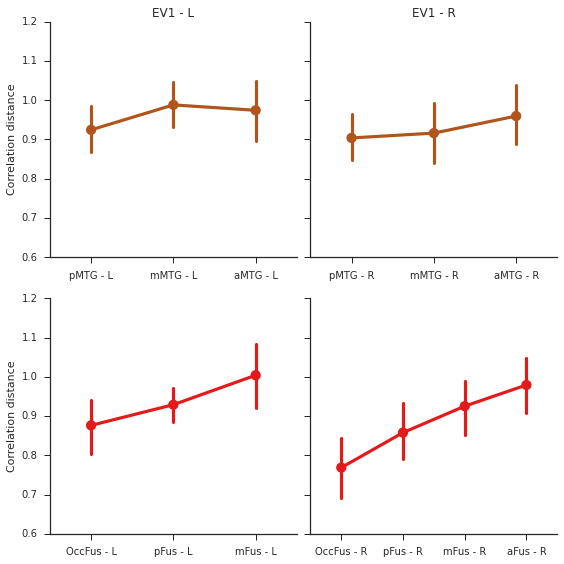

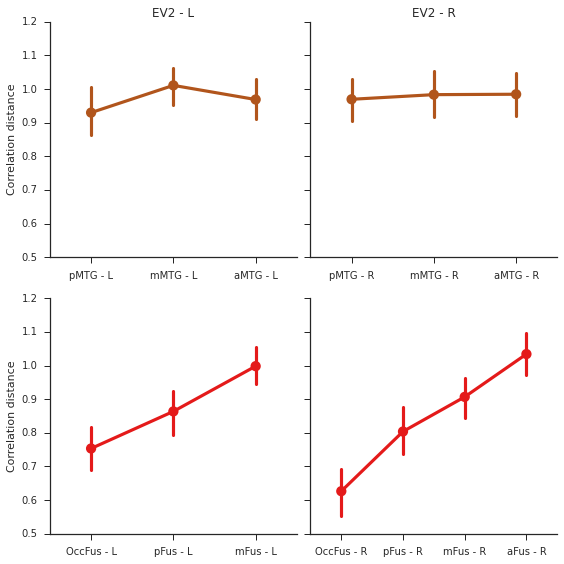

In [17]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(8, 8))
plot_distance(roi_dist, dorsal_rois, color='#b1551c', axs=axs[0], 
              order=['EV1 - L', 'EV1 - R'])
plot_distance(roi_dist, ventral_rois, color='#e41a1a', axs=axs[1], title=False,
             order=['EV1 - L', 'EV1 - R'])
plt.tight_layout()
#fig.savefig(pjoin(img_dir, 'distance_ifg.png'), dpi=300)

fig, axs = plt.subplots(2, 2, sharey=True, figsize=(8, 8))
plot_distance(roi_dist, dorsal_rois, color='#b1551c', axs=axs[0], 
              order=['EV2 - L', 'EV2 - R'])
plot_distance(roi_dist, ventral_rois, color='#e41a1a', axs=axs[1], title=False,
             order=['EV2 - L', 'EV2 - R'])
plt.tight_layout()
fig.savefig(pjoin(img_dir, 'distance_ev.png'), dpi=300)

Now we compute the mean within each system (dorsal | ventral), and compute an index as follows


$$
I = \frac{d(\text{ventral}, \text{EV}) - d(\text{dorsal}, \text{EV})}{d(\text{ventral}, \text{EV}) + d(\text{dorsal}, \text{EV})}
$$

such that

$$
\begin{array}*
I > 0 & \text{if EV is closer to the dorsal stream} \\
I < 0 & \text{if EV is closer to the ventral stream} \\
I = 0 & \text{if EV is equidistant to the dorsal and ventral streams}\\
\end{array}
$$


In [18]:
# extract means for each subject and each system
def compute_distance_from_roi(roi, roistoaverage, labels_original, roi_distances):
    """
    Computes average distances of one roi to a list of rois.
    
    Arguments
    ---------
    roi : str
    roistoaverage : list of str
    labels_original : list of str
        the original labels in order as `roi_distances`
    roi_distances : list of mvpa2.Dataset
        square datasets containing the distances between ROIs,
        each dataset is coming from one subject
    
    Returns
    -------
    ds_ : array (len(roi_distances), )
        distances from roi to roistoaverage
    """
    i_row = idx_labels([roi], labels_original)
    i_cols = idx_labels(roistoaverage, labels_original)
    ds_ = []
    for ds in roi_distances:
        ds_.append(ds.samples[np.ix_(i_row, i_cols)].mean())
    ds_ = np.array(ds_)
    return ds_

mean_dorsal = dict()
mean_ventral = dict()
for roi in dorsal_rois:
    compareto_dorsal = dorsal_rois[roi]
    compareto_ventral = ventral_rois[roi]
    # extract the averages across dorsal and ventral ROIs
    mean_dorsal[roi] = compute_distance_from_roi(roi, compareto_dorsal, labels_original, roi_dist)
    mean_ventral[roi] = compute_distance_from_roi(roi, compareto_ventral, labels_original, roi_dist)

In [19]:
# make a dataframe for plotting
df_dorsal = pd.DataFrame(mean_dorsal)
df_dorsal['system'] = 'dorsal'

df_ventral = pd.DataFrame(mean_ventral)
df_ventral['system'] = 'ventral'

df = pd.concat((df_dorsal, df_ventral))
df_long = pd.melt(df, id_vars='system')

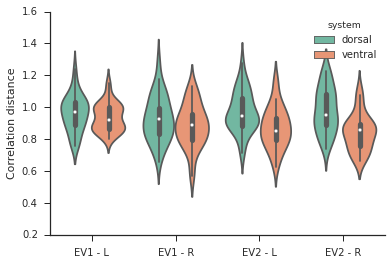

In [20]:
fig, ax = plt.subplots(1, 1)
sns.violinplot(x='variable', y='value', hue='system',
               data=df_long, palette=sns.color_palette('Set2'), ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Correlation distance')
sns.despine()
fig.savefig(pjoin(img_dir, 'violin_dist_ev.png'), dpi=300)

In [21]:
# now compute the index
def compute_index(a, b):
    return (a-b)/(a+b)
df_difference = compute_index(df_ventral.iloc[:, :4], df_dorsal.iloc[:, :4])
df_difference_long = pd.melt(df_difference)

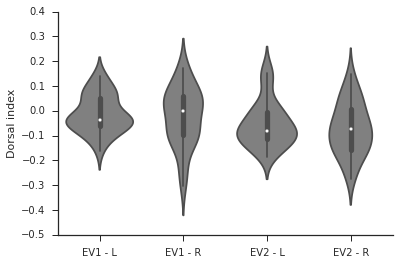

In [22]:
fig, ax = plt.subplots(1, 1)
sns.violinplot(x='variable', y='value', color='gray',
              data=df_difference_long, ax=ax, )
ax.set_xlabel('')
ax.set_ylabel('Dorsal index')
sns.despine()
fig.savefig(pjoin(img_dir, 'violin_index_ev.png'), dpi=300)

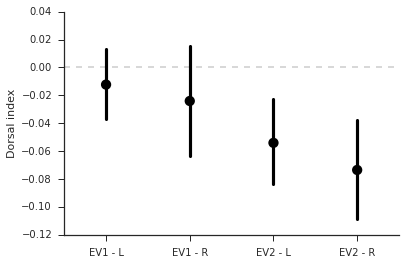

In [23]:
fig, ax = plt.subplots(1, 1)
ax.axhline(color='lightgray', linestyle='dashed')
sns.pointplot(x='variable', y='value', color='black', join=False, n_boot=10000, 
              data=df_difference_long, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Dorsal index')
sns.despine()
fig.savefig(pjoin(img_dir, 'pointplot_index_ev.png'), dpi=300)

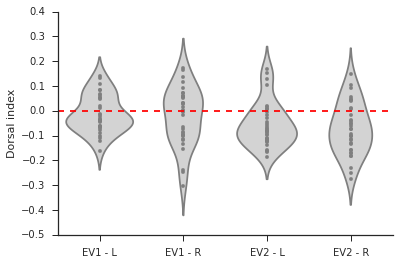

In [24]:
fig, ax = plt.subplots(1, 1)
ax.axhline(color='red', linestyle='dashed')
sns.violinplot(x='variable', y='value', color='lightgray',
              data=df_difference_long, ax=ax, inner='point')
ax.set_xlabel('')
ax.set_ylabel('Dorsal index')
sns.despine()
fig.savefig(pjoin(img_dir, 'pointplot_index_ev.png'), dpi=300)

Now bootstrap the index to obtain confidence intervals for those values

In [25]:
# bootstrapping
nrows = len(df_difference)
nbs = 10000
df_difference_bs = []
np.random.seed(765)
for idx in xboost(nrows, nbs):
    df_difference_bs.append(df_difference.iloc[idx].mean(axis=0))
df_difference_bs = pd.concat(df_difference_bs, axis=1).T

cis = np.percentile(df_difference_bs, [2.5, 97.5], axis=0).T
avg = df_difference.mean(axis=0)

In [26]:
for lbl, a, ci in zip(avg.index.tolist(), avg, cis):
    print("{0}: {1} {2}".format(lbl, np.round(a, 2), np.round(ci, 2)))

EV1 - L: -0.01 [-0.04  0.01]
EV1 - R: -0.02 [-0.07  0.01]
EV2 - L: -0.05 [-0.08 -0.02]
EV2 - R: -0.07 [-0.11 -0.04]
